<center>
<img src='https://64.media.tumblr.com/72ca42a775d24a7f1c3c914b967fcd75/tumblr_pdqcnftNaV1w67ki0o2_500.gifv' align='center' width="500x">
</center>

# Андан на экономе

## Семинар 8:  регуляризация, подбор гиперпараметров

Мы довольно подробно поговорили про линейную регрессию и добрались до переобучения. В этом семинаре мы дадим ему бой с помощью регуляризации. А также мы научимся подбирать гиперпараметры.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Что у нас уже есть

На прошлых парах мы обсудили, какую предобработку данных нужно сделать и обучили линейную регрессию. Давайте скопипастим код.

In [2]:
df = pd.read_csv('train.csv', index_col=0)
print(df.shape)
df.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
from sklearn.model_selection import train_test_split

y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])
feature_names = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__Вопроc:__ зачем мы разбивали выборку на тест и трэйн?

In [4]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()  # считаем средние на трэйне
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)   # применяем к тесту средние с трэйна

__Вопроc:__ зачем заполнять пропуски? Какие способы сделать это вы знаете?

In [5]:
from sklearn.preprocessing import StandardScaler

# Дальше мы работаем только с числовыми признаки
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train[numeric_features])
X_test_scaled = scaler_x.transform(X_test[numeric_features])

__Вопроc:__ что такое нормализация данных, зачем её делать?

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1347
Train MAPE = 0.1249


In [7]:
from sklearn.preprocessing import PolynomialFeatures

polinom_transform = PolynomialFeatures(2, include_bias=False)

X_train_poly = polinom_transform.fit_transform(X_train_scaled)
X_test_poly = polinom_transform.transform(X_test_scaled)

In [8]:
model = LinearRegression()

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1915603513.4185
Train MAPE = 0.0611


In [9]:
X_train_poly.shape

(1168, 702)

In [10]:
np.abs(model.coef_)[:10]

array([4.40539678e+02, 1.19756746e+13, 2.22939713e+13, 5.43488718e+13,
       9.48779241e+12, 5.10831667e+13, 1.86260077e+13, 6.00027050e+13,
       1.61746369e+15, 5.44219444e+14])

In [11]:
np.abs(model.coef_).sum()

9.313861602944227e+16

In [12]:
np.abs(model.coef_)[:10].sum()

2389501326706936.5

__Вопрос:__ почему при добавлении степеней качество модели на тесте так резко упало? Что такое переобучение?

![](https://miro.medium.com/max/875/1*_7OPgojau8hkiPUiHoGK_w.png)

Что мы видим по моделям? Крутые завихрения, большие коэффициенты около переменных. Возникает идея: если искусственно стянуть коэффициенты к нулю, модель не будет так сильно извиваться ине переобучиться. Из-за ограничения на коэффициенты, она станет проще. Такие дополнительные условия называются **регуляризацией.**

## 2. Ridge-регрессия (гребневая регрессия)

Давайте посмотрим, что поменяется по сравнению с обычной линейной регрессией. Снова будем смотреть на случай с одной объясняющей переменной. Формула для расчёта прогнозов никак не изменится. 

__Модель:__ 

$$
y_i = w \cdot x_i
$$

А вот функция потерь уже будет другой. Появится дополнительное слагаемое. Если коэффициенты оказались по модулю очень большими, к функции потерь будет добавляться дополнительный штраф. Сила этого штрафа задаётся гиперпараметром $\lambda$. Мы его выбираем перед обучением модели. 

__Функция потерь:__

$$
Q(w) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat y_i)^2 + \lambda \cdot w^2 =  \frac{1}{n} \sum_{i=1}^n (y_i - w \cdot x_i)^2 + \lambda \cdot w^2 \to \min_{w}
$$

Попробуем найти оптимальное $w$, взяв производную и приравняв её к нулю. 

$$
\frac{\partial Q}{\partial w} = - \frac{2}{n} \sum_{i=1}^n (y_i - w \cdot x_i) x_i + 2 \lambda w = 0
$$

$$
\sum_{i=1}^n x_i y_i -  w \sum_{i=1}^n x^2_i - n \lambda w = 0
$$

$$
\sum_{i=1}^n x_i y_i =  w \left( \sum_{i=1}^n x^2_i + \lambda \cdot n\right)
$$


__Решение:__

$$
\hat{w} = \frac{ \sum_{i=1}^n x_i y_i }{\sum_{i=1}^n x^2_i + \lambda \cdot n}
$$

Если $\lambda = 0,$ тогда регуляризации нет, оценка коэффициента совпадает с обычной линейной регрессией. Если мы берём очень большое $\lambda,$ мы получаем близкие к нулю коэффициенты. Гиперпараметр $\lambda$ отвечает за силу регуляризации. 

In [13]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=200) # альфа это лямбда :)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1178
Train MAPE = 0.0720


Качество на тестовой выборке стало намного лучше. Давайте попробуем перебрать разные значения $\alpha$ и посмотрим, как коэффициенты стягиваются к нелю по мере его роста.

In [14]:
alphas = np.logspace(-2, 5, 20)
coefs = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)

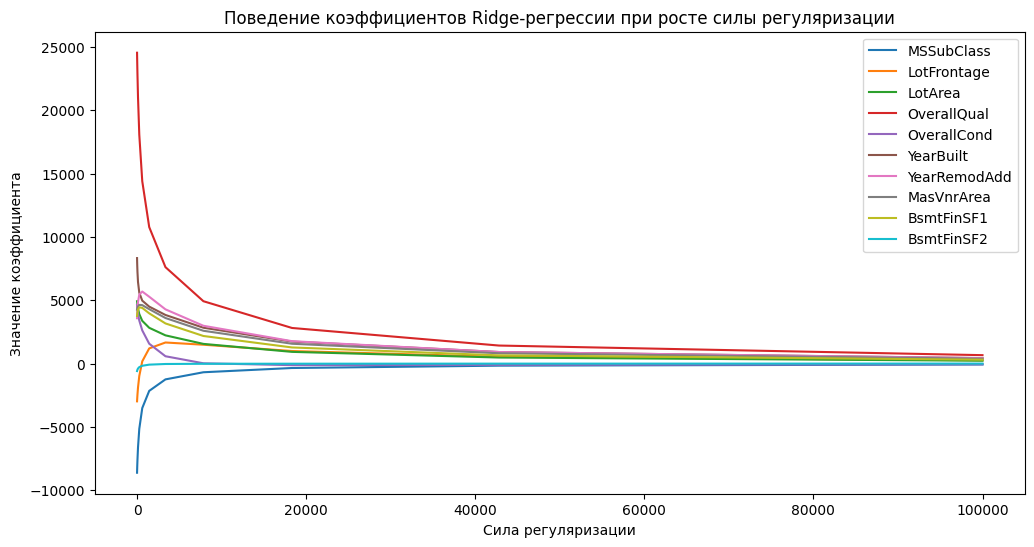

In [15]:
df_coef = pd.DataFrame(coefs)
df_coef.columns = numeric_features
df_coef.index = alphas

df_coef[numeric_features[:10]].plot(figsize=(12,6))
plt.xlabel("Сила регуляризации")
plt.ylabel("Значение коэффициента")
plt.title('Поведение коэффициентов Ridge-регрессии при росте силы регуляризации');

Видно, что коэффициенты всё ближе к нулю при росте лямбды, но в ноль они не превращаются. 

**Вопрос:** почему в случае Ridge регрессии очень важно отмасштабировать признаки?

## 3. Поиск гиперпараметра по решётке

Наряду с параметрами (веса $w$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` — коэффициент регуляризации. 

Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 162.3777


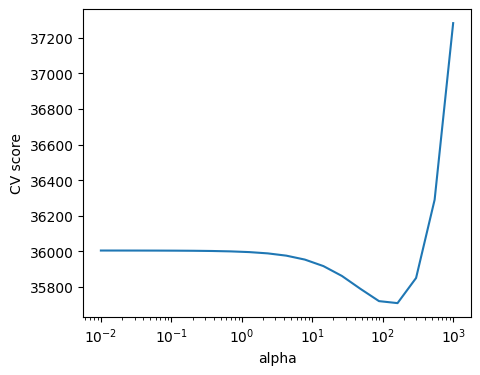

In [16]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(
    Ridge(), [{"alpha": alphas}], 
    scoring="neg_root_mean_squared_error", cv=10
)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.figure(figsize=(5,4))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

**Вопрос:** Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Выше мы делали перебор каждого из возможных значений. Иногда комбинаций существует очень много. В таком случае используют другие способы перебора. Например, случайный поиск `RandomSearch`.

<center>
<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZTlQm_WRcrNqL-nLnx6GJA.png' align='center' width="600x">
</center>

Есть даже библиотеки для подбора гиперпараметров. Например, в [`optuna`](https://github.com/optuna/optuna) реализована [куча более умных методов.](https://habr.com/ru/post/704432/) Подробнее про подбор гиперпараметров можно почитать [в ШАДовском учебнике.](https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov)

## 4. Lasso-регрессия

В случае ridge-регрессии мы накладывали штраф на коэффициенты как их квадрат

$$
Q(w) = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat y_i)^2 + \lambda \cdot \sum_{j=1}^k w_j^2.
$$

Можно попробовать использовать модуль

$$
Q(w) = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat y_i)^2 + \lambda \cdot \sum_{j=1}^k |w_j|.
$$

Такая модель называется LASSO-регрессией. В отличие от Ridge-регрессии, она умеет занулять коэффициенты.

In [17]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=200)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1176
Train MAPE = 0.0716


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.527e+08, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Посмотрим, как при росте штрафа коэффициенты будут зануляться.

In [18]:
alphas = np.logspace(-2, 5, 20)
coefs = []

for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)

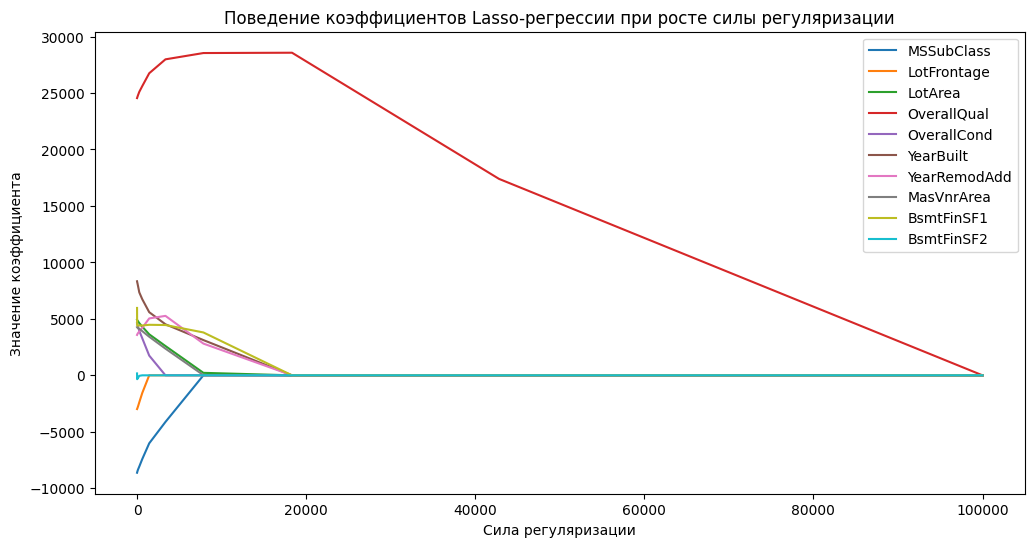

In [19]:
df_coef = pd.DataFrame(coefs)
df_coef.columns = numeric_features
df_coef.index = alphas

df_coef[numeric_features[:10]].plot(figsize=(12,6))
plt.xlabel("Сила регуляризации")
plt.ylabel("Значение коэффициента")
plt.title('Поведение коэффициентов Lasso-регрессии при росте силы регуляризации');

Почему это так? Ответ таится на картинке ниже...

![](https://miro.medium.com/max/761/1*nrWncnoJ4V_BkzEf1pd4MA.png)

Ещё можно использовать оба регуляризатора сразу. Такая модель называется [`ElasticNet`.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

## 5. Pipeline

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [20]:
y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])
feature_names = X.columns.values

# пока что работаем только с числовыми признаками
numeric_features = X.select_dtypes([np.number]).columns
X = X[numeric_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для заполнения пропусков можно использовать класс `SimpleImputer`

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

simple_pipeline = Pipeline([
    ('fillna', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1280
Train MAPE = 0.0716


## 6. Категориальные признаки

Давайте добавим категориальные признаки. Напомним, что для них в каестве предобработки можо использовать one hot encoding.

Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию `pd.get_dummies`.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр `OneHotEncoder(sparse = True)` или `.get_dummies(sparse=True)`, и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

In [22]:
y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])
feature_names = X.columns.values

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

# пропуски для категориальных фичей будут отдельной категорией
X[categorical_features] = X[categorical_features].fillna("NotGiven")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

__Вопрос:__ почему в категориальной переменной мы заполнили все пропуски одинаковым значением?

In [23]:
# Пропуски в действительных числах
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first",
                         min_frequency=0.001), categorical_features)
])

Посмотрим на размеры матрицы после OneHot-кодирования:

In [25]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.fit_transform(X_train).shape)

Size before OneHot: (1168, 79)
Size after OneHot: (1168, 250)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. Выше мы обсудили, что $\ell_1$-регуляризатор разреживает признаковое пространство, иными словами, такая модель зануляет часть весов.

In [26]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1163
Train MAPE = 0.0716


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79409219347.51859, tolerance: 696659484.3571943
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 7


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]

Best alpha = 61.5848


Text(0, 0.5, 'CV score')

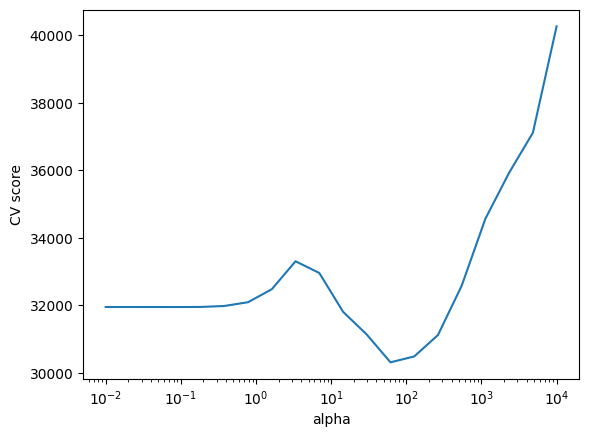

In [29]:
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [30]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))

Test MAPE = 0.1156


/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 110


## 7. Как устроены трансформеры для данных (бонус для сильных)

Реализуем класс для нормализации данных по аналогии с интерфейсом sklearn для нормализации.

Предобработка данных в sklearn реализована по похожему шаблону, что и обучение моделей: функция `.fit(X)` запоминает внутренние переменные, а функция `.transform(X)` выполняет преобразование выборки. y здесь не нужен, потому что в нормализации целевые переменные не участвуют (как и почти во всей предобработке данных).

Параметров у класса нет, так что функцию `__init__` мы пропускаем. Функция `.fit()` считает статистики - среднееи стандартное отклонение каждого признака (по обучающей выборке), а функция `.tranform()` вычитает среднее и делит на стандартное отклонение. Для вычисления статистик используем numpy.

In [32]:
class Normalizer:
    def fit(self, X: np.array) -> None:
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0)
        
    def transform(self, X: np.array) -> np.array:
        return (X - self.mu[np.newaxis, :]) / self.sigma[np.newaxis, :]

Создадим случайные данные для теста.

In [33]:
num_obj_train = 20
num_obj_te = 10
num_feat = 4
X_train = np.random.randint(-5, 5, size=(num_obj_train, num_feat))
X_train.shape

(20, 4)

In [34]:
X_test = np.random.randint(-5, 5, size=(num_obj_te, num_feat))
X_test.shape

(10, 4)

In [35]:
X_train

array([[ 2,  3,  4, -3],
       [ 2,  4,  4,  0],
       [-2,  1, -3,  4],
       [ 3,  4,  2,  2],
       [ 2,  1, -5,  1],
       [-1,  2,  2,  1],
       [-1,  0, -4, -3],
       [ 2,  4,  1,  1],
       [-1, -3, -4,  3],
       [-3,  3,  0,  3],
       [-5,  0, -4, -3],
       [ 4, -5,  2, -3],
       [-3,  1, -1, -3],
       [-4, -1, -4, -5],
       [-3,  1, -3,  3],
       [ 3,  1, -5,  0],
       [ 1, -5, -2,  3],
       [-4,  2, -1, -3],
       [ 0,  2, -5,  2],
       [-2,  2, -4,  3]])

Создаем объект класса и трансформируем выборку:

In [36]:
normalizer = Normalizer()
normalizer.fit(X_train)
X_train_transformed = normalizer.transform(X_train)
X_test_transformed = normalizer.transform(X_test)

Fit нужно вызывать именно на обучающих данных, чтобы ничего не подсмотреть в контрольной выборке. А transform можно вызывать много раз для любых выборок (с уже посчитанным статистиками, которые хранятся внутри класса).

In [37]:
X_train_transformed

array([[ 0.94155447,  0.83514828,  1.83844724, -1.14811442],
       [ 0.94155447,  1.22358934,  1.83844724, -0.05467212],
       [-0.56493268,  0.05826616, -0.5013947 ,  1.40325096],
       [ 1.31817626,  1.22358934,  1.16992097,  0.67428942],
       [ 0.94155447,  0.05826616, -1.16992097,  0.30980865],
       [-0.18831089,  0.44670722,  1.16992097,  0.30980865],
       [-0.18831089, -0.3301749 , -0.83565784, -1.14811442],
       [ 0.94155447,  1.22358934,  0.83565784,  0.30980865],
       [-0.18831089, -1.49549809, -0.83565784,  1.03877019],
       [-0.94155447,  0.83514828,  0.5013947 ,  1.03877019],
       [-1.69479805, -0.3301749 , -0.83565784, -1.14811442],
       [ 1.69479805, -2.27238021,  1.16992097, -1.14811442],
       [-0.94155447,  0.05826616,  0.16713157, -1.14811442],
       [-1.31817626, -0.71861596, -0.83565784, -1.87707596],
       [-0.94155447,  0.05826616, -0.5013947 ,  1.03877019],
       [ 1.31817626,  0.05826616, -1.16992097, -0.05467212],
       [ 0.56493268, -2.

## Почиташки


- [Лекции Жени Соколова про линейные модели](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture04-linregr.pdf)
- [Семинар про линейные модели с ФКН](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem02-sklearn-linregr.ipynb)
- [Анализ малых данных (блог А.Дьяконова). Разброс и смещение](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
- [Kaggle. Ridge,Lasso, ElasticNet Regressions Explained](https://www.kaggle.com/fugacity/ridge-lasso-elasticnet-regressions-explained)


Youtube видео с визуализациями:

* [Ridge Regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Lasso Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [Ridge vs Lasso Regression visualized](https://www.youtube.com/watch?v=Xm2C_gTAl8c&ab_channel=StatQuestwithJoshStarmer)